In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

In [3]:
SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
IMAGE_SIZE = 224 
BATCH_SIZE = 32
EPOCHS = 10
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Loading the Dataset

In [5]:
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/ML Implementation/Corn-disease/corn_disease_dataset/data",
     shuffle = True,
     seed=SEED,
     image_size = (IMAGE_SIZE, IMAGE_SIZE),
     batch_size = BATCH_SIZE
)

Found 4814 files belonging to 4 classes.


In [6]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [7]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(32, 224, 224, 3)
[3 2 1 2 1 1 0 3 0 1 1 1 1 1 2 2 3 2 0 2 2 0 2 1 3 1 0 1 2 1 1 2]


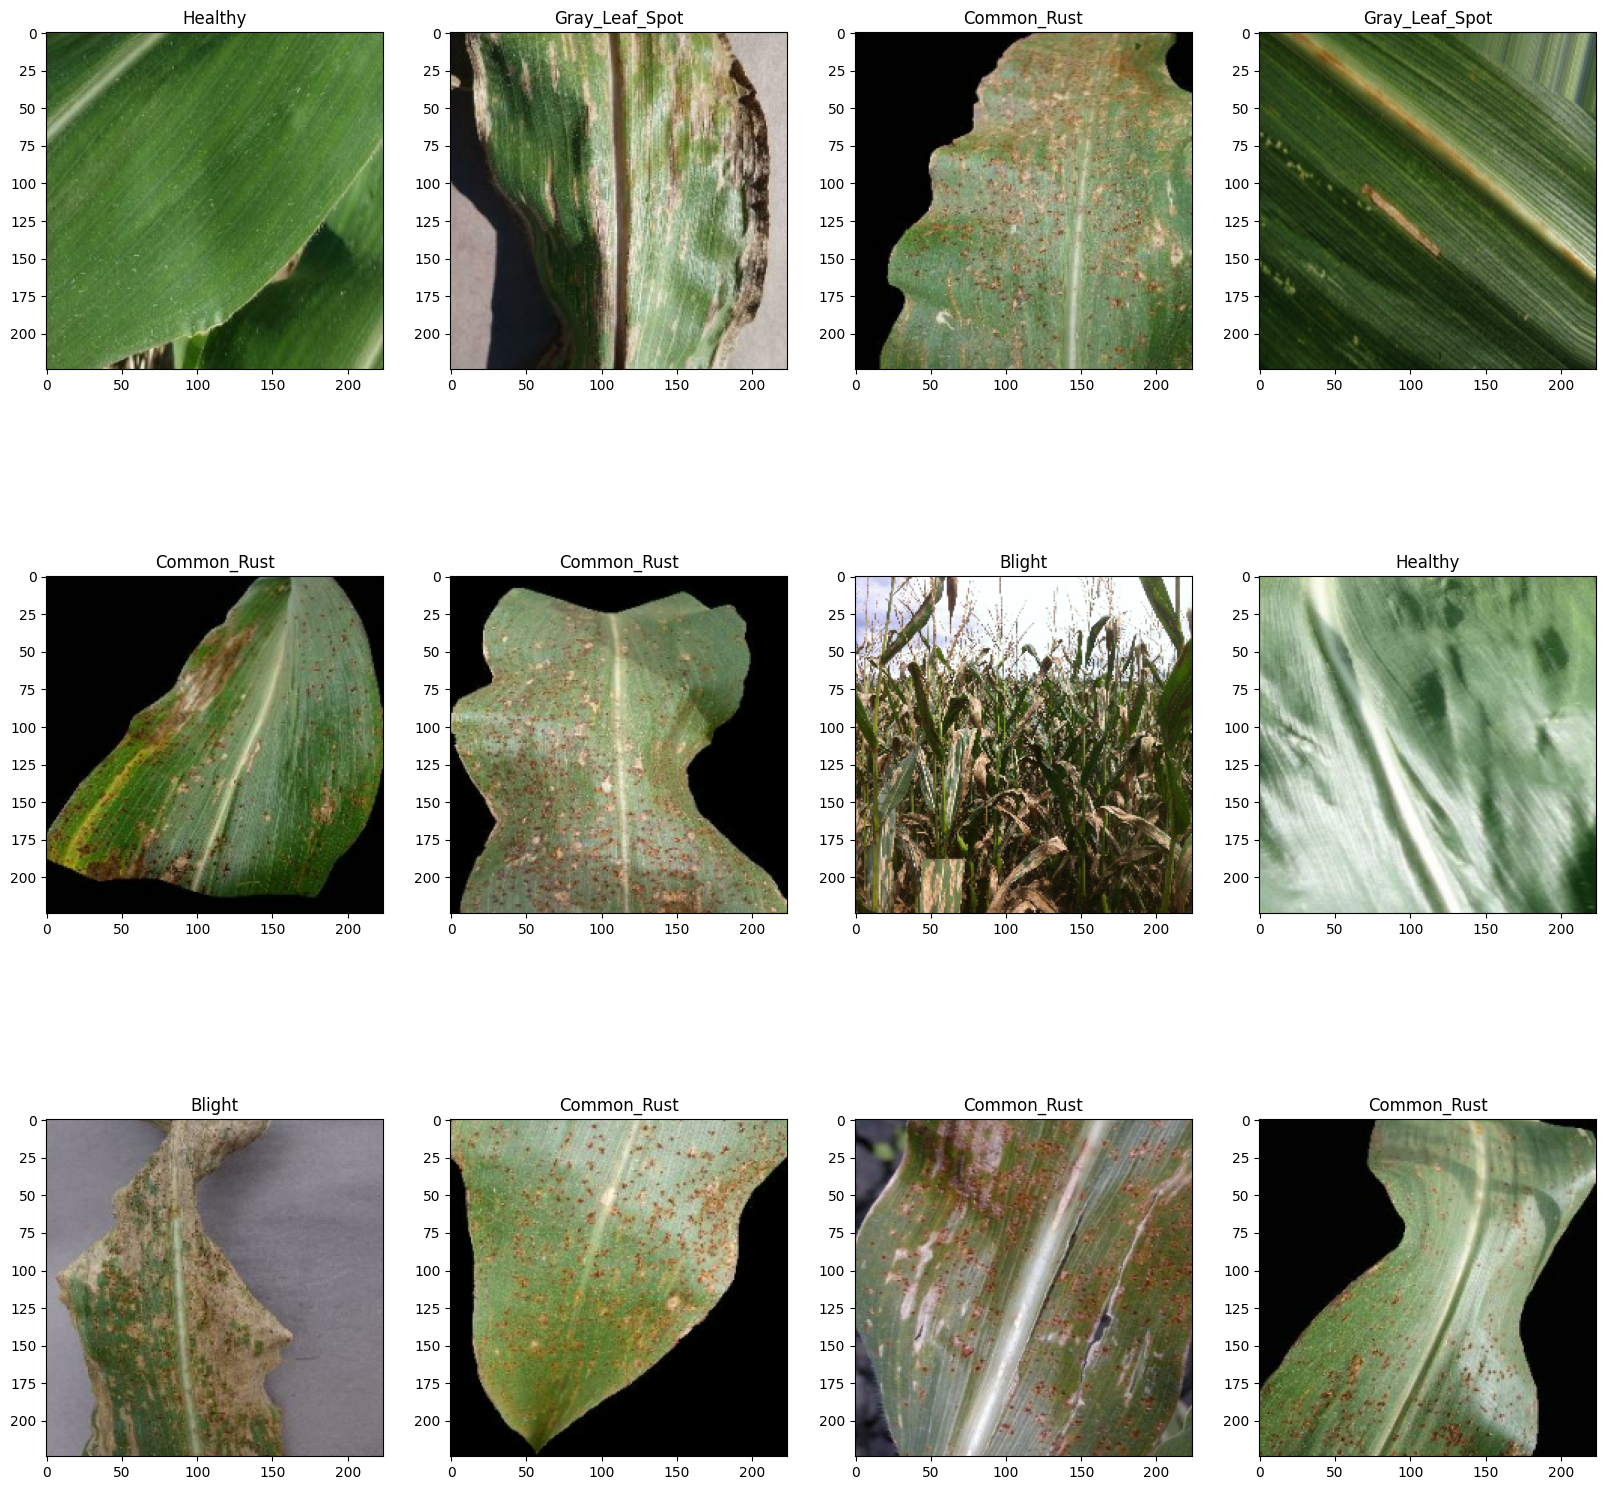

In [8]:
plt.figure(figsize = (20,20)) # Lets increse plot size of our plots
#Lets explore our batch and display some images
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
    #To visualize all images plot as subplot 
        ax = plt.subplot(3,4,i+1)
    #Visualize image using matplotlib imshow function plt.imshow expects a 3D numpy array
        plt.title(class_names[label_batch[i]]) # Displaying its class label as title
        plt.imshow(image_batch[i].numpy().astype('uint8'))
    print(image_batch.shape)
    print(label_batch.numpy())

In [9]:
y = np.concatenate([y for x, y in dataset], axis=0)
print(np.bincount(y))#np.bincount(array) counts occurence of each element in array.

[1146 1306 1200 1162]


# Data Partition

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Count dataset size
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

120

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Rescaling & Augmentation

In [14]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])


In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [16]:
# Apply resize & rescale to all datasets
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [17]:
# Apply augmentation only to training
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=AUTOTUNE)

# Loading the Model : VGG19

In [19]:
from keras.applications import VGG19
vgg19 = VGG19(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 8s 0us/step


### Not training the existing weights

In [20]:
for layer in vgg19.layers:
    layer.trainable = False

In [21]:
x = tf.keras.layers.Flatten()(vgg19.output)

prediction = tf.keras.layers.Dense(4, activation='softmax')(x)

# create a model object
model = tf.keras.models.Model(inputs=vgg19.input, outputs=prediction)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Fitting the model

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds)
)

Epoch 1/10
120/120 [==============================] - 495s 4s/step - loss: 0.5562 - accuracy: 0.8112 - val_loss: 0.2814 - val_accuracy: 0.8979
Epoch 2/10
120/120 [==============================] - 489s 4s/step - loss: 0.3224 - accuracy: 0.8841 - val_loss: 0.2458 - val_accuracy: 0.8958
Epoch 3/10
120/120 [==============================] - 492s 4s/step - loss: 0.3163 - accuracy: 0.8909 - val_loss: 0.2315 - val_accuracy: 0.9292
Epoch 4/10
120/120 [==============================] - 495s 4s/step - loss: 0.2893 - accuracy: 0.8935 - val_loss: 0.1996 - val_accuracy: 0.9312
Epoch 5/10
120/120 [==============================] - 503s 4s/step - loss: 0.2872 - accuracy: 0.9013 - val_loss: 0.2445 - val_accuracy: 0.9167
Epoch 6/10
120/120 [==============================] - 490s 4s/step - loss: 0.3333 - accuracy: 0.8906 - val_loss: 0.2236 - val_accuracy: 0.9146
Epoch 7/10
120/120 [==============================] - 498s 4s/step - loss: 0.3010 - accuracy: 0.8997 - val_loss: 0.2592 - val_accuracy: 0.9062

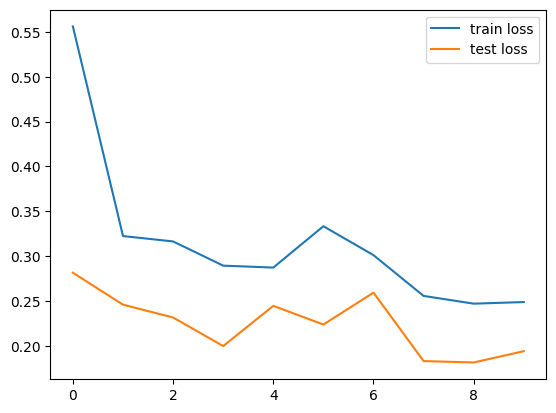

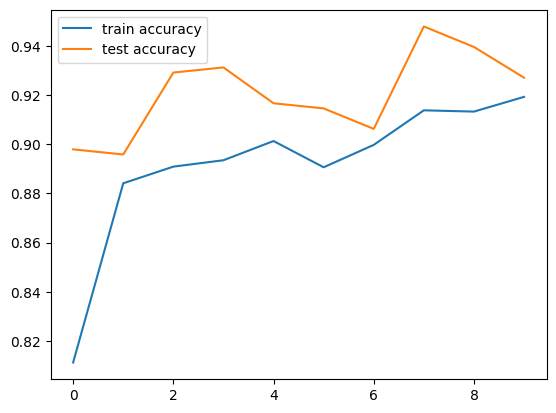

<Figure size 640x480 with 0 Axes>

In [25]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('Loss over Epochs')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy over Epochs')

first image to print


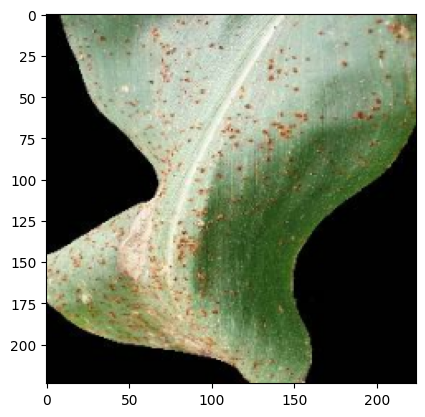

first image actual label: Common_Rust
1/1 [==============================] - 4s 4s/step
predicted label: Common_Rust


In [26]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy() * 255).astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to print")
    plt.imshow(first_image)
    plt.show()

    print("first image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])


In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 153ms/step


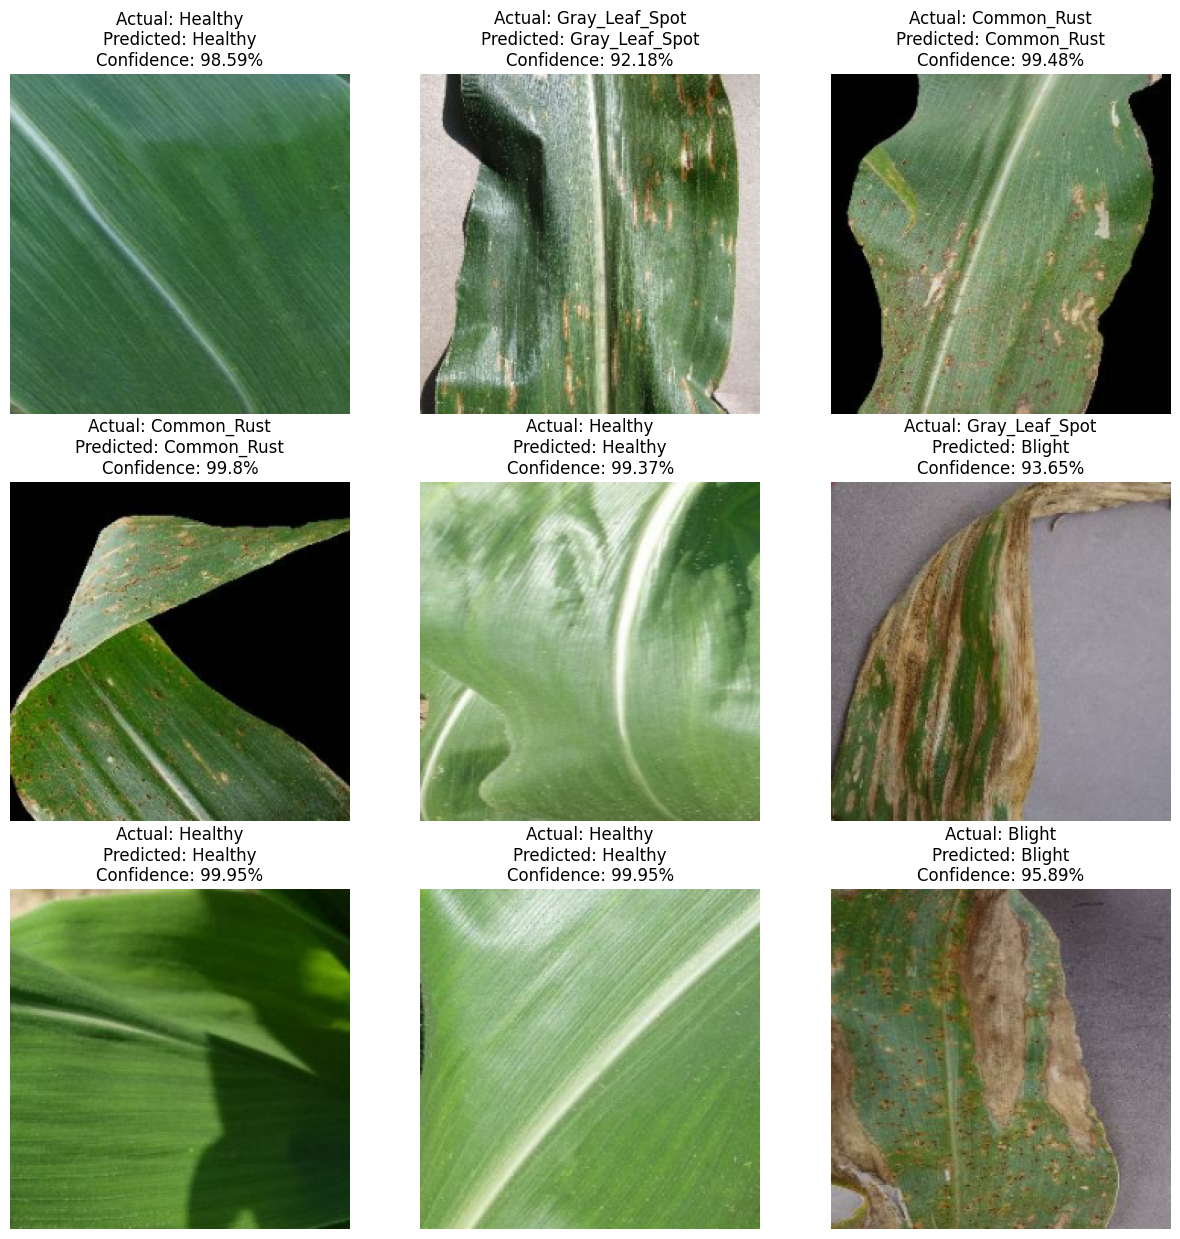

In [28]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # rescale for display
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")


# Model Predictions

In [29]:
import numpy as np

y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)  # shape (batch_size,)
    true_classes = labels.numpy()             # shape (batch_size,)
    

    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)
    
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)  

1/1 [==============================] - 4s 4s/step


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

## Accuracy

In [31]:
acc = accuracy_score(y_true, y_pred)

In [32]:
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 92.71%


## Precision

In [33]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'

In [34]:
print(f"Precision: {precision * 100:.2f}%")

Precision: 93.73%


## Recall

In [35]:
recall = recall_score(y_true, y_pred, average='weighted')

In [36]:
print(f"Recall: {recall * 100:.2f}%")

Recall: 92.71%


## F1-Score

In [37]:
f1 = f1_score(y_true, y_pred, average='weighted')

In [38]:
print(f"f1: {f1 * 100:.2f}%")

f1: 92.88%


## Confusion Matrix

In [39]:
cm = confusion_matrix(y_true, y_pred)

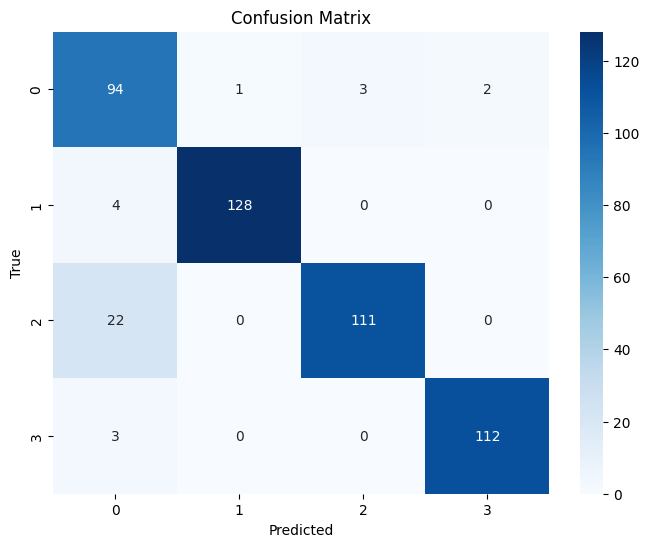

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# AUROC

In [41]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)


Macro-Averaged ROC-AUC Score: 99.33%


In [42]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\ML Implementation\Corn-disease


In [43]:
model_version= "VGG19_224"
model.save(f"./models/{model_version}.keras")